In [1]:
import pandas as pd
import csv
import numpy as np
import string
import re
import tensorflow as tf

In [2]:
wordsVector = np.load('glove_word2Vec/wordVectors.npy')
wordsList = np.load('glove_word2Vec/wordsList.npy').tolist()
wordsList = [word.decode('UTF-8') for word in wordsList]

In [3]:
print(wordsVector.shape)
print(len(wordsList))

(400000, 50)
400000


## Load Data

Now we will load the movie review data. 
The data comes from https://www.kaggle.com/c/word2vec-nlp-tutorial/data

In [4]:
data = pd.read_table("movie_review_dataset/labeledTrainData/labeledTrainData.tsv", sep='\t')

Split training and testing datasets


Set seed to make sure the split is always the same

In [5]:
from sklearn.model_selection import train_test_split

train_reviews, test_reviews = train_test_split(data, test_size=0.4, train_size=0.6, random_state=3957)

In [6]:
train_reviews.head()

,id,sentiment,review
20398,3622_8,1,I knew I was going to see this when I saw the ...
12556,10348_1,0,I was very excited to see that they had made a...
3482,10477_9,1,Walking the tightrope between comedy and drama...
10592,12053_9,1,Well-done ghost story that will give you the c...
17762,7441_3,0,"To quote the film, \It's better not to know. B..."


In [7]:
train_reviews.shape

(15000, 3)

In [8]:
test_reviews.head()

,id,sentiment,review
23728,4492_1,0,The first Matrix movie was lush with incredibl...
3598,4801_4,0,I really wanted to like this movie. It has a n...
4373,11063_3,0,I do have the `guts' to inform you to please s...
4668,10621_10,1,"Simply put, this is the best movie to come out..."
17114,10050_2,0,A huge disappointment from writer Hamm and dir...


In [9]:
test_reviews.shape

(10000, 3)

## Exploratory analysis

Exploring the number of words in each review 

In [10]:
def review_len(review):
    review = review.translate(string.punctuation)
    review = review.split(" ")
    return len(review)

In [11]:
num_words = train_reviews.apply(lambda row: review_len(row['review']), axis=1)

In [12]:
num_words.describe()

count    15000.000000
mean       232.976667
std        172.972896
min         12.000000
25%        126.000000
50%        174.000000
75%        285.000000
max       2470.000000
dtype: float64

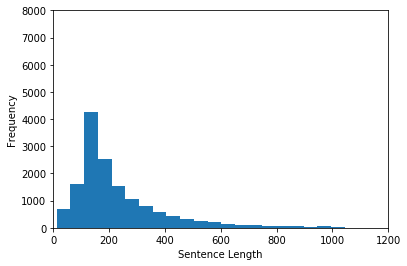

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(num_words, 50)
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.axis([0, 1200, 0, 8000])
plt.show()

In [14]:
maxSeqLength = 250
numDimensions = 300

### Converting sentences

 Creating a utility function to convert reviews into a numpy array of words.

In [15]:
def convert_sentence(sentence):
    # Got from analysis below.
    maxSeqLength = 250
    index_count = 0
    
    remove_special_chars = re.compile("[^A-Za-z0-9 ]+")
    
    sentence = sentence.lower()
    sentence = sentence.translate(string.punctuation)
    sentence = re.sub(remove_special_chars, "", sentence)
    sentence = sentence.split(" ")
    if len(sentence) > maxSeqLength:
        sentence = sentence[:maxSeqLength]
    sentenceList = np.zeros((maxSeqLength), dtype='int32')
    for word in sentence:
        try:
            sentenceList[index_count] = wordsList.index(word)
        except ValueError:
            # TODO create a vector for unknow words
            # https://groups.google.com/forum/#!topic/globalvectors/n6BYywiENGo
            sentenceList[index_count] = 399999 # Vector for unkown words
            
        index_count = index_count + 1
        
    return np.array(sentenceList)

In [16]:
testSent = "Hello, how are you doing today?"

testSentVec = convert_sentence(testSent)

print(testSentVec)

[13075   197    32    81   914   373     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [17]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordsVector, testSentVec).eval().shape)

(250, 50)


## Converting words to word vecs

Code in this section has been commented out as it takes quite alot of time to run it.
Instead we can just load data from a csv file

#### TODO

We may have to have all reviews be of the same length. This is kind of inconvinient since we will lose information.
Check if anyone has a solution to this.

##### UPDATE 6/12/2017
Now that we end up with a list of lists from this conversion, it may be possible to have the internal lists be of different length. Because I am converting the list to a DataFrame I wont try to have different lengths yet.

First, try this with a subset of the training data. Maybe the first 500 rows.

In [ ]:
# subset_reviews = train_reviews.iloc[0:500]

Using apply wasn't working correctly so I decided to use a list comprehension

In [ ]:
# subset_reviews_ids = [convert_sentence(row[3]) for row in subset_reviews.itertuples()]

In [ ]:
# subset_reviews_ids = pd.DataFrame(subset_reviews_ids)
# subset_reviews_ids.shape

In [ ]:
# subset_reviews_ids.head(2)

Now apply it to whole dataset. 

This takes a **LONG** time to run therefore, I have saved the output files as a csvs which can be loaded to avoid this step.

#### Converting training data

In [ ]:
# train_reviews_ids = [convert_sentence(row[3]) for row in train_reviews.itertuples()]
# train_reviews_ids_df = pd.DataFrame(train_reviews_ids)
# train_reviews_ids_df.to_csv("movie_review_dataset/labeledTrainData/train_ids_matrix.csv", index=False)

#### Converting testing data

In [ ]:
# test_reviews_ids = [convert_sentence(row[3]) for row in test_reviews.itertuples()]
# test_reviews_ids_df = pd.DataFrame(test_reviews_ids)
# test_reviews_ids_df.to_csv("movie_review_dataset/labeledTrainData/test_ids_matrix.csv", index=False)

In [ ]:
# train_reviews_ids_df.shape

In [ ]:
# train_reviews_ids_df.head()

In [ ]:
# test_reviews_ids_df.shape

In [ ]:
# test_reviews_ids_df.head()

#### TODO: remove drop once new version of csv is created

In [18]:
train_reviews_ids_df = pd.read_csv("movie_review_dataset/labeledTrainData/train_ids_matrix.csv")

In [19]:
test_reviews_ids_df = pd.read_csv("movie_review_dataset/labeledTrainData/test_ids_matrix.csv")

## RNN Model

Setting hyper parameters

In [20]:
batch_size = 24
lstm_units = 64
num_classes = 2
itterations = 100000

In [21]:
import tensorflow as tf
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batch_size, num_classes])
input_data = tf.placeholder(tf.int32, [batch_size, maxSeqLength])

In [22]:
data = tf.Variable(tf.zeros([batch_size, maxSeqLength, numDimensions]), dtype=tf.float32)
data = tf.nn.embedding_lookup(wordsVector, input_data)

In [23]:
lstm_cell = tf.contrib.rnn.BasicLSTMCell(lstm_units)
lstm_cell = tf.contrib.rnn.DropoutWrapper(cell=lstm_cell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstm_cell, data, dtype=tf.float32)

In [24]:
weight = tf.Variable(tf.truncated_normal([lstm_units, num_classes]))
bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [25]:
correctPred = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [26]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [27]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

## Train Network



#### Testing for functions  -  Delete later

In [ ]:
# train_reviews.head()
train_reviews.iloc[1, 1]

In [ ]:
train_reviews_ids_df.head()

In [ ]:
(train_reviews_ids_df.shape[0]-1)

In [ ]:
from random import randint

test = randint(1, train_reviews_ids_df.shape[0]-1)
ans = train_reviews_ids_df[test-1:test].as_matrix()

print(ans)
print(type(ans))


In [ ]:
a, b = getTrainBatch()

print(a[0])
print(b[0])

In [ ]:
train_reviews.head(2)

In [ ]:
pos = train_reviews['sentiment'] == 0

In [ ]:
len(pos)

In [ ]:
train_reviews_ids_df.index.get_values()

In [ ]:
train_reviews.index = train_reviews_ids_df.index

In [ ]:
positive_reviews = train_reviews_ids_df.loc[train_reviews['sentiment'] == 1]
negative_reviews = train_reviews_ids_df.loc[train_reviews['sentiment'] == 0]

In [ ]:
positive_reviews.shape

In [ ]:
negative_reviews.shape

In [ ]:
# train_reviews['sentiment'] == 1

In [ ]:
pos.head()

In [ ]:
nextBatch, nextBatchLabels = getTrainBatch()

In [ ]:
nextBatch.shape

In [ ]:
nextBatchLabels

In [ ]:
nextBatch[0]

#### Testing for functions  -  Delete later ABOVE

In [28]:
from random import randint

# Helper functions to provide data for batch
def getTrainBatch():
    train_reviews.index = train_reviews_ids_df.index
    positive_review_ids = train_reviews_ids_df[train_reviews['sentiment'] == 1]
    negative_review_ids = train_reviews_ids_df[train_reviews['sentiment'] == 0]
    
    labels = []
    arr = np.zeros([batch_size, maxSeqLength])
    
    for i in range(batch_size):
        if (i % 2 == 0):
            num = randint(1, positive_review_ids.shape[0]-1)
            arr[i] = positive_review_ids[num-1:num].as_matrix() 
            labels.append([1, 0])
        else:
            num = randint(1, negative_review_ids.shape[0]-1)
            arr[i] = negative_review_ids[num-1:num].as_matrix()
            labels.append([0, 1])
    
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batch_size, maxSeqLength])
    
    for i in range(batch_size):
        num = randint(1, test_reviews_ids_df.shape[0]-1)
        arr[i] = test_reviews_ids_df[num-1:num].as_matrix()
        labels.append([1, 0]) if train_reviews.iloc[i, 1] == 1 else labels.append([0, 1])
    return arr, labels

In [ ]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(itterations):
    # Get next batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch()
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
    
    #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)
        
    #Save the network every 10,000 training iterations
    if(i % 10000 == 0 and i != 0):
        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step = 1)
        print("saved to %s" % save_path)

writer.close()

saved to models/pretrained_lstm.ckpt-1
saved to models/pretrained_lstm.ckpt-1
saved to models/pretrained_lstm.ckpt-1
saved to models/pretrained_lstm.ckpt-1
